In [1]:
%reload_ext autoreload
%autoreload 2
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from utils.bigram import *
from utils.helpers import *

# read trainset
train_data, val_data, vocab_size, decode = prepare_txt_data()

# instantiate model
model = BigramLanguageModel(vocab_size)
model = nn.DataParallel(model)
model = model.to(device) # move model parameters to gpu if available

device: cuda
vocab:  
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab_size: 65
num_params: 34M


In [2]:
# Create a pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # usually 3e-4 for bigger networks.

list_epochs, list_losses, list_epochs_eval, list_losses_eval = [0], [], [0], [] 
xb, yb = get_batch(train_data, batch_size)
logits, loss = model(xb, yb)
if device.startswith('cuda'):
    loss = loss.mean()

list_losses.append(loss.tolist())

losses = estimate_loss(model, train_data, val_data, eval_iters, -1, time.time())
list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])

print(f'logits.shape: {logits.shape}')
print(f'loss: {loss:.3f}')
print(r''.join(decode(generate(model, torch.zeros((1,1), device=device, dtype=torch.long),
                               max_new_tokens=100)[0].tolist())))

step    -1: train_loss 4.3047, val_loss: 4.3007  (...Runtime: 0 min 20 sec)
logits.shape: torch.Size([16384, 65])
loss: 4.313

SNYYsCyaW?xbwfw:l;J.hEeaH-arqJyRniE!L'VE c
vvwb,RCGSjeN3Z.ulxZcQiSZf 
bEODZoRmYHd-iaDU'd3izefcN?zM
u


step   500: train_loss 1.9925, val_loss: 2.0902  (...Runtime: 1 min 55 sec)
step  1000: train_loss 1.5940, val_loss: 1.7809  (...Runtime: 3 min 51 sec)
step  1500: train_loss 1.4223, val_loss: 1.6252  (...Runtime: 5 min 46 sec)
step  2000: train_loss 1.3298, val_loss: 1.5661  (...Runtime: 7 min 42 sec)
step  2500: train_loss 1.2672, val_loss: 1.5316  (...Runtime: 9 min 37 sec)
step  3000: train_loss 1.2126, val_loss: 1.5158  (...Runtime: 11 min 33 sec)
step  3500: train_loss 1.1699, val_loss: 1.4993  (...Runtime: 13 min 28 sec)
step  4000: train_loss 1.1320, val_loss: 1.4833  (...Runtime: 15 min 23 sec)
step  4500: train_loss 1.0924, val_loss: 1.4837  (...Runtime: 17 min 19 sec)
step  5000: train_loss 1.0586, val_loss: 1.4879  (...Runtime: 19 min 14 sec)
step  5500: train_loss 1.0186, val_loss: 1.5070  (...Runtime: 21 min  9 sec)
step  6000: train_loss 0.9826, val_loss: 1.5276  (...Runtime: 23 min  3 sec)
step  6500: train_loss 0.9501, val_loss: 1.5430  (...Runtime: 24 min 58 sec)
step

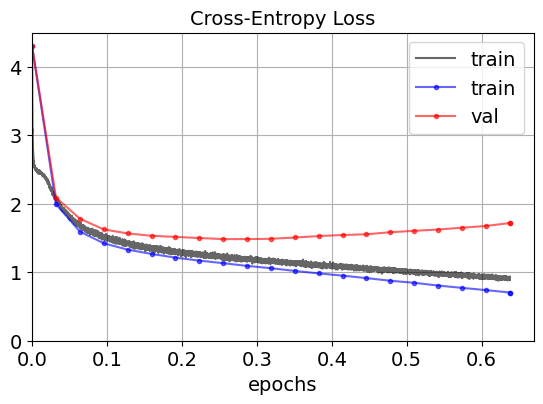

In [3]:
# train loop
start = time.time()
epoch = 0

for ib in range(1, max_iters + 1):
    # sample a batch of data
    xb, yb = get_batch(train_data, batch_size)
    
    # evaluate the loss
    logits, loss = model(xb, yb)
    if device.startswith('cuda'):
        loss = loss.mean()
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # get the gradients
    optimizer.step() # update parameters using the gradients
    
    # evaluate at fixed intervals
    epoch += batch_size / (len(train_data)-batch_size)
    if ib % eval_interval == 0 or ib == max_iters - 1:
        losses = estimate_loss(model, train_data, val_data, eval_iters, ib, start)
        list_epochs_eval.append(epoch)
        list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])
    list_losses.append(loss.item())
    list_epochs.append(epoch)
    
plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval)

# Generate text 
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(r''.join(decode(generate(model, torch.zeros((1,1), device=device, dtype=torch.long), 
                               max_new_tokens=400)[0].tolist()))) 

# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's anodes in a graph looking at each other and aggregating informtaion with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


## Experiments
---

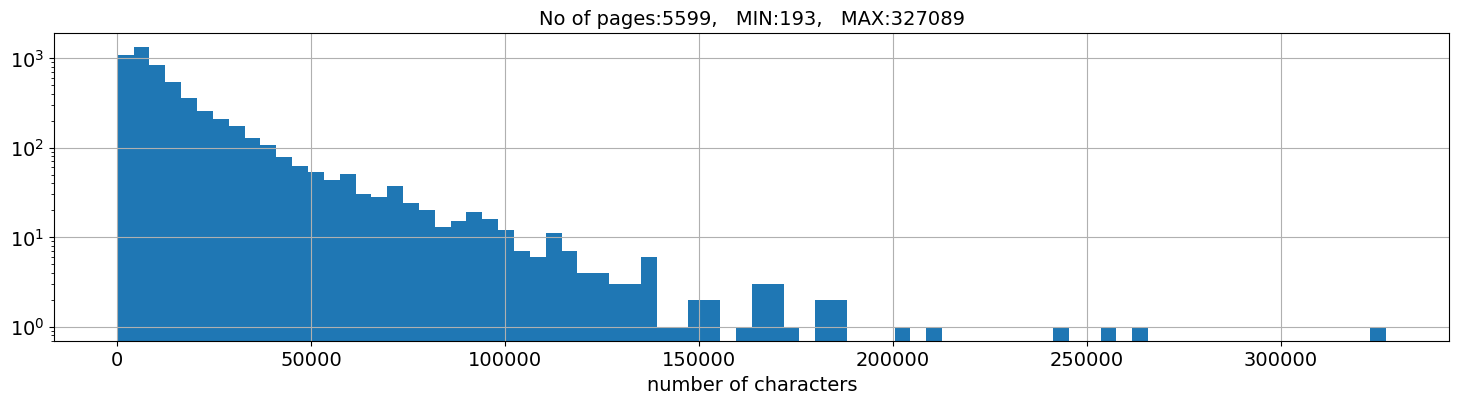

In [2]:
dirname='dataset/wikis/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of pages:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


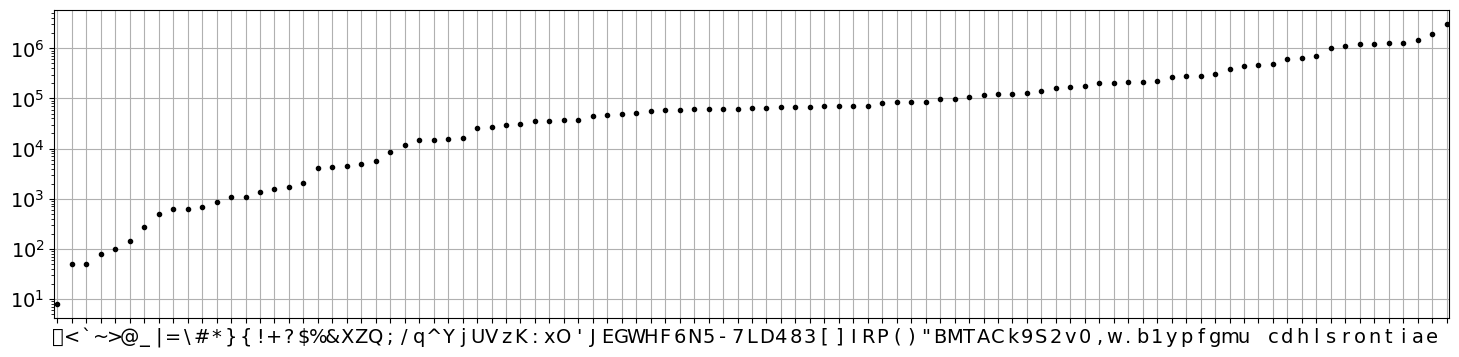

In [8]:
cnt = plot_character_frequency(urls[:1000], wikis, vocab)

In [4]:
text = clean_up(text)
print(text)

American singer, songwriter, and musician (1923 1953)
For other people named Hank Williams, see Hank Williams (disambiguation).
Hank WilliamsWilliams in 1951BornHiram Williams(1923-09-17)September 17, 1923Butler County, Alabama, U.S.DiedJanuary 1, 1953(1953-01-01) (aged 29)Oak Hill, West Virginia, U.S.Resting placeOakwood Annex CemeteryMontgomery, Alabama, U.S.32 23 05 N 86 17 29 W / 32.3847 N 86.2913 W / 32.3847; -86.2913Other namesThe Singing KidLovesick Blues BoyLuke the DrifterThe Hillbilly ShakespeareOccupationsSingersongwritermusicianYears active1937 1952Spouses
Audrey Sheppard
 (m. 1944; div. 1952) 
Billie Jean Horton (m. 1952) 
Relatives
Hank Williams Jr. (son)
Jett Williams (daughter)
Hank Williams III (grandson)
Holly Williams (granddaughter)
Coleman Williams (great-grandson)
Musical careerGenresCountryWesternhonky-tonkgospelInstrument(s)VocalsguitarfiddleLabelsSterlingMGM
Musical artistSignature
Hiram "Hank" Williams (September 17, 1923 January 1, 1953) was an American singe